In [6]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
%config Completer.use_jedi = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import os, sys
home = os.path.expanduser("~")
sys.path.append(os.path.join(home,'github','QDMpy','src'))

import numpy as np
from scipy import stats

%matplotlib inline
import matplotlib
matplotlib.rcParams["figure.figsize"] = (4,3)

import matplotlib.pyplot as plt

In [8]:
import QDMpy

# The data format

QDM data from the QDMio system is stored in binary MATLAB files. The QDMio datafiles can be read with either `scipy.io.loadmat` of `mat73.loadmat` depending on the size (version of matlab file). The return value is a dictionary.

In [6]:
# from scipy.io import loadmat
# from mat73 import loadmat as loadmat73 # for matlab files with version 7.3

from QDMpy.utils import loadmat

In [7]:
# this is a dataset, which has been binned with bin=8. The reflected light and laser images, however are untouched.
# Be aware that binning this set with bin <=8 is not possible.
path_to_the_qdm_datafolder = QDMpy.TEST_DATA_PATH / "utrecht_test_data"

In [8]:
pos_field = loadmat(os.path.join(path_to_the_qdm_datafolder, 'run_00000.mat'))
neg_field = loadmat(os.path.join(path_to_the_qdm_datafolder, 'run_00001.mat'))

In [9]:
pos_field.keys()

dict_keys(['__header__', '__version__', '__globals__', 'disp1', 'disp2', 'freqList', 'imgNumCols', 'imgNumRows', 'imgStack1', 'imgStack2', 'numFreqs'])

It contains several "variables". `disp1` and `disp2` are the mean spectra for the left and right frequency range respectively. 
`imgStack1` and `imgStack2` are the raw data of the measurement. 

Notes: 
- the data is normalized internally in teh QDM Labview software. 
- in the case of 101 frequencies, there are two additional variables: `imgStack3` and `imgStack4`

The other variables show the size of the image and the number of frequencies used.

# The ODMR object

## creating an instance
### manually

This is a container for the QDM raw ODMR data. A new instance can be created by directly specifying the data, scan_dimensions and frequencies used to measure.

For this, we will need to prepare the data first.

In [10]:
from QDMpy.core import ODMR

The ODMR objects expects the data to be formatted like `[polarity, f_range, n_pixels, n_freqs]` with each on a searate axis, therefor we need to create an array with that composition.

In [11]:
odmr_data = np.array([[pos_field['imgStack1'], pos_field['imgStack2']], [neg_field['imgStack1'], neg_field['imgStack2']]])
odmr_data = odmr_data.swapaxes(-1,-2) # swap pixel/frequency axes
odmr_data.shape

(2, 2, 36000, 51)

Lets check that this is correct. The `imgStack2` of the first file (`pos_field`) is the high frequency mesurement range and as such must be the same as index `[0,1]` in the new array. We only need to transpose the array because the QDMio file is stored as [frequency, pixel] and we want [pixel, frequency].

In [12]:
np.allclose(pos_field['imgStack2'].T, odmr_data[0,1])

True

The scan_dimensions can be extracted from the `imgNumRows` and `imgNumCols` variables stored in the matlab file.

In [13]:
scan_dimensions = tuple([pos_field['imgNumRows'][0,0], pos_field['imgNumCols'][0,0]])
scan_dimensions

(150, 240)

We also need to format the frequency list. Here, all frequencies are saved in a single long array, so we split it.

In [14]:
frequencies = np.array([pos_field['freqList'][0,:51], pos_field['freqList'][0,51:]])
frequencies.shape

(2, 51)

Now we can create a new innstance of the ODMR object.

In [15]:
odmr_manual = ODMR(data=odmr_data, scan_dimensions=scan_dimensions, frequencies=frequencies)

10:35:35     INFO QDMpy._core.odmr.__init__ >> ODMR data object initialized
10:35:35     INFO QDMpy._core.odmr.__init__ >> ODMR data format is [polarity, f_range, n_pixels, n_freqs]
10:35:35     INFO QDMpy._core.odmr.__init__ >> read parameter shape: data: (2, 2, 36000, 51)
10:35:35     INFO QDMpy._core.odmr.__init__ >>                       scan_dimensions: (150, 240)
10:35:35     INFO QDMpy._core.odmr.__init__ >>                       frequencies: (2, 51)
10:35:35     INFO QDMpy._core.odmr.__init__ >>                       n(freqs): 51


While this worked fine, when larger fields are applied, the data files have two additional variables `imgStack3` and `imgStack4` due to the larger data (at least in the current version 2022 of the QDM software). This makes the manual creation is more complicated.

Luckily, QDMpy has a more simple option to do all of the above in one line of code.

### Automatic instance creation

Automatic creation is done with the `from_qdmio` method. For this to work, 2 `run_*.mat` fiels need to be present in the `path_to_the_qdm_datafolder` otherwise importing will raise a .

Note: other data formats can be added to the class by implementing the `from_other_format` method.

In [16]:
odmr_inst = ODMR.from_qdmio(path_to_the_qdm_datafolder)

10:35:36     INFO QDMpy._core.odmr.from_qdmio >> Reading 2 run_* files.
10:35:36     INFO QDMpy._core.odmr.__init__ >> ODMR data object initialized
10:35:36     INFO QDMpy._core.odmr.__init__ >> ODMR data format is [polarity, f_range, n_pixels, n_freqs]
10:35:36     INFO QDMpy._core.odmr.__init__ >> read parameter shape: data: (2, 2, 36000, 51)
10:35:36     INFO QDMpy._core.odmr.__init__ >>                       scan_dimensions: [150 240]
10:35:36     INFO QDMpy._core.odmr.__init__ >>                       frequencies: (2, 51)
10:35:36     INFO QDMpy._core.odmr.__init__ >>                       n(freqs): 51


The resulting object should have the same data.

In [17]:
np.allclose(odmr_manual.data, odmr_inst.data)

True

## Accessing the data
As we have seen in the comparison above, the ODMR data is stored in `ODMR.data`. However, it may be easier to access it using the custom indexing.

In [18]:
# get the low frequency data (left side of the spectrum)
odmr_inst['<']
# get the high frequency data
odmr_inst['>']
# get the positive field data
odmr_inst['+']
# get the negrative field data
odmr_inst['-']

array([[[0.99977747, 0.99997477, 0.99971039, ..., 0.99820958,
         0.99840327, 0.99834935],
        [0.99987568, 0.99978441, 0.99981226, ..., 0.99849667,
         0.99850178, 0.99827344],
        [0.99996246, 0.99955943, 1.        , ..., 0.99859275,
         0.99862117, 0.99849382],
        ...,
        [0.99980955, 1.        , 0.99956842, ..., 0.99887518,
         0.99874418, 0.99878362],
        [1.        , 0.99999192, 0.99985756, ..., 0.99892448,
         0.99881693, 0.99887159],
        [0.99997609, 0.99991979, 0.99987287, ..., 0.99919649,
         0.9987899 , 0.99862442]],

       [[0.99834058, 0.9985715 , 0.99846113, ..., 0.99958003,
         0.9998326 , 1.        ],
        [0.99824017, 0.99819834, 0.99826827, ..., 0.9994389 ,
         0.99980574, 1.        ],
        [0.99848198, 0.9983115 , 0.99842385, ..., 0.99970622,
         0.99957824, 1.        ],
        ...,
        [0.9983692 , 0.9986536 , 0.9986573 , ..., 0.99981282,
         0.99989257, 1.        ],
        [0.9

All these can be combined to yield the positive low frequency data, for instance.

In [19]:
odmr_inst['<+']

array([[1.        , 0.99981879, 0.99991575, ..., 0.99821624, 0.99838223,
        0.99828834],
       [0.99992468, 1.        , 0.99999133, ..., 0.99844832, 0.99848963,
        0.99849291],
       [0.99981786, 1.        , 0.99978434, ..., 0.99840744, 0.99851491,
        0.9983014 ],
       ...,
       [0.9999679 , 1.        , 0.99977173, ..., 0.99856427, 0.99861504,
        0.99865983],
       [1.        , 0.99997395, 0.9997494 , ..., 0.99883719, 0.99876319,
        0.99890261],
       [1.        , 0.99982607, 0.99967749, ..., 0.99867732, 0.99856906,
        0.99858889]])

If you check the data shape, here all pixels are stored row by row in a long array.

In [20]:
odmr_inst['<+'].shape

(36000, 51)

This makes it harder to get the data of the pixel at x = 42, and y = 99 for example. So you can use `'r'` to get the data reshaped into a 2D array.

Now finding the pixel is easy (Note: x = col, y = row and numpy uses [row, col] which can be confusing)

Text(0.5, 0, 'f [GHz]')

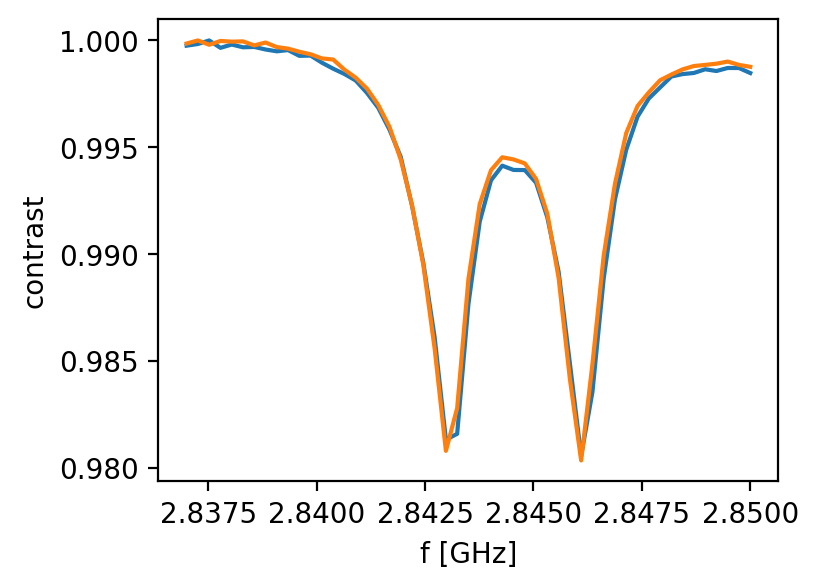

In [22]:
plt.plot(odmr_inst.f_ghz[0], odmr_inst['<+r'][99,42])
plt.plot(odmr_inst.f_ghz[0], odmr_inst['<-r'][99,42])
plt.ylabel('contrast')
plt.xlabel('f [GHz]')

#### advanced indexing
Obviously you can access te data in `ODMR.data` like any other numpy array, and as we just saw you can index the ODMR object using `'<>+-r'` but you can also use `rc2idx` and `idx2rc` to get the index from row and column values and viceversa.

In teh example above, x = 42 and y = 99 have r = 99 and c = 42. Lets find the index of the corresponding pixel.


In [24]:
idx = odmr_inst.rc2idx((99,42))
idx

23802

This will give you the exact same plot as above.

Text(0.5, 0, 'f [GHz]')

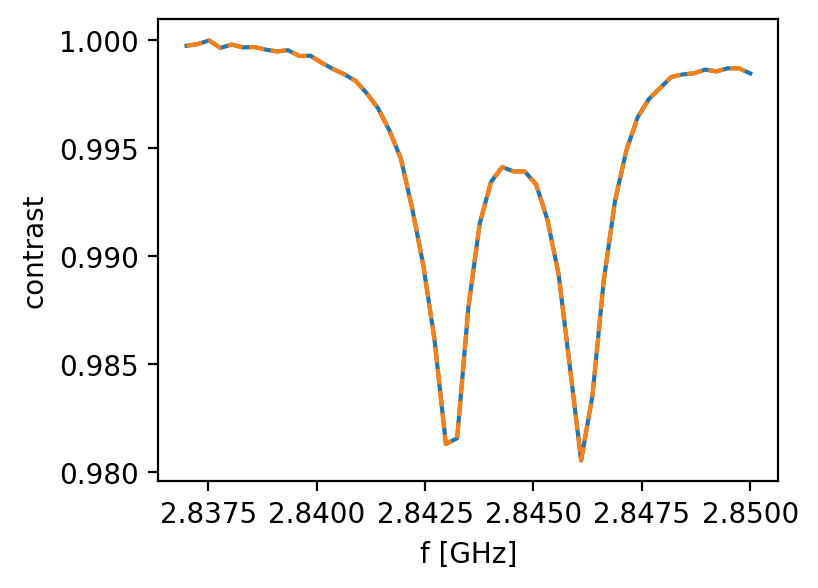

In [25]:
plt.plot(odmr_inst.f_ghz[0], odmr_inst['<+'][idx])
plt.plot(odmr_inst.f_ghz[0], odmr_inst['<+r'][99,42], ls='--')

plt.ylabel('contrast')
plt.xlabel('f [GHz]')

Similarly, the method `idx2rc` does the opposite and shour return our x = 42 and y = 99.

In [26]:
odmr_inst.idx2rc(idx)

(array([99]), array([42]))

## Data manipulation
### data binning

In most cases, we use binning to get better signal-to-noise ratio. This also reduces the filesize and all calculations are done more quickly. However, we lose some spatial resolution doing this.

Binning the data is done with `ODMR.bin_data(bin_factor)`.

Note: the dataset 'utrecht_test_data' is already binned with `bin_factor = 8` so that it can be uploaded to the github repository.

In [27]:
odmr_inst.bin_data(bin_factor=2)

10:37:34     INFO QDMpy._core.odmr._bin_data >> Binned data from 2x2x150x240x51 --> 2x2x75x120x51


AS you can see, this reduces the image from 150x240 -> 75x120. Internally we use `skimage.measure.block_reduce` with `np.nanmean` to calculate the mean of a `bin_factor x bin_factor` window.

You can also reset the binning by just binning again with `bin_factor = 1`.

In [28]:
odmr_inst.bin_data(bin_factor=1)

10:38:28     INFO QDMpy._core.odmr._bin_data >> Binned data from 2x2x150x240x51 --> 2x2x150x240x51


To see what is happening internally, lets set the logging to debug and run it again.

In [29]:
QDMpy.LOG.setLevel("DEBUG")

In [30]:
odmr_inst.bin_data(bin_factor=1)

10:38:39    DEBUG QDMpy._core.odmr._apply_edit_stack >> Applying edit stack
10:38:39    DEBUG QDMpy._core.odmr.reset_data >> Resetting data to raw data.
10:38:39    DEBUG QDMpy._core.odmr.get_norm_factors >> Determining normalization factor from maximum value of each pixel spectrum. Shape of mx: (2, 2, 36000)
10:38:39    DEBUG QDMpy._core.odmr._normalize_data >> Normalizing data with method: max
10:38:39    DEBUG QDMpy._core.odmr._bin_data >> Binning data [150 240] with factor 1 (pre bin factor: 1)
10:38:39     INFO QDMpy._core.odmr._bin_data >> Binned data from 2x2x150x240x51 --> 2x2x150x240x51


In [27]:
odmr_inst.bin_data(bin_factor=2)

15:11:52    DEBUG QDMpy._core.odmr._apply_edit_stack >> Applying edit stack
15:11:52    DEBUG QDMpy._core.odmr.reset_data >> Resetting data to raw data.
15:11:52    DEBUG QDMpy._core.odmr.get_norm_factors >> Determining normalization factor from maximum value of each pixel spectrum. Shape of mx: (2, 2, 36000)
15:11:52    DEBUG QDMpy._core.odmr._normalize_data >> Normalizing data with method: max
15:11:52    DEBUG QDMpy._core.odmr._bin_data >> Binning data [150 240] with factor 2 (pre bin factor: 1)
15:11:52     INFO QDMpy._core.odmr._bin_data >> Binned data from 2x2x150x240x51 --> 2x2x75x120x51


As you can see there is quite a lot happening 'under the hood'. Because we are manipulating the data irreversibly, I am using a what I call `edit stack`. If you make any change tho the processing, the whole stack is reapplied. While this is rather time-consuming for larger datasets, it ensures, that nothing unexpected happens to the data.
The stack (so far) is defined as follows:

0. reset the data to original (i.e. the data as it is in the file)
1. normalize the data (`ODMR.normalize_data`)
2. bin the data (`ODMR.bin_data`)
3. apply outlier mask (`apply_outlier_mask`)
4. correct global fluorescence (`correct_global_fluorescence`)

### Global fluorescence correction

ODMR daa also contains an additional signal, which stems from teh internal reflections within a diamond. We call this the global fluorescecne, in contrast to the local fluorescence at the pixel. The total signal, therefore, is `total = global + local`.  This signal is a typically a zero field signal.
We can subtract that signal by specifying the portion of the global signal to the total signal (e.g. 0.2 -> 20% of the total signal is the global fluorescence).

In [31]:
QDMpy.LOG.setLevel("INFO")

In [32]:
odmr_inst.correct_glob_fluorescence(0.2)

10:42:29     INFO QDMpy._core.odmr._bin_data >> Binned data from 2x2x150x240x51 --> 2x2x150x240x51
10:42:29     INFO QDMpy._core.odmr._correct_glob_fluorescence >> Correcting for global fluorescence with value 0.2


If you look closely at the log, you can see that the whole `edit_stack` is again applied. This behavior is unfortunate and should if possible be changed as it takes a lot of time doing this every time.

An easy way to check the way the global_factor affects the signal and wether you have corrected enough/too much, is the `ODMR.check_blob_fluorescence` method. You can specify a new `global_factor` and it will show you a plot of the pixel, that most diverges from the mean (see: `ODMR.most_divergent_from_mean`).

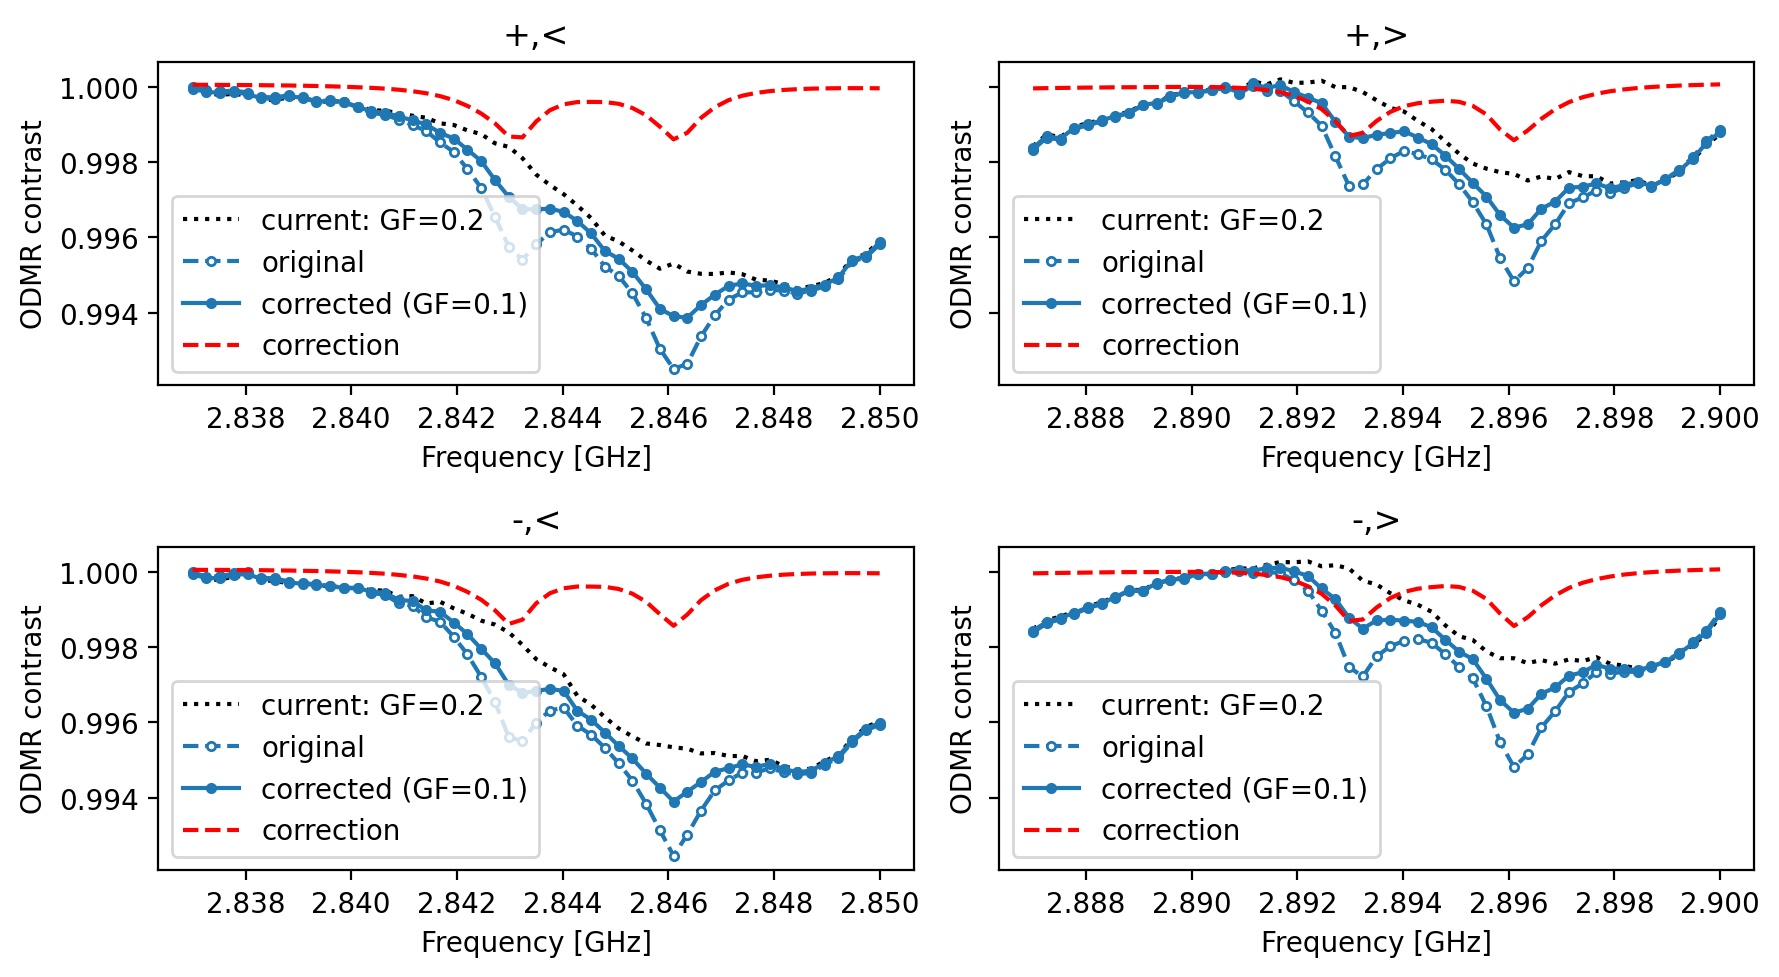

In [33]:
odmr_inst.check_glob_fluorescence(0.1)

# The Fit object

In [31]:
from QDMpy.core import Fit

The fit class is a container for the data and handles all the fitting related things. In theory you should not need to create one on your own, but lets go through it anyways.

In [32]:
fit_inst = Fit(data=odmr_inst.data, frequencies = odmr_inst.f_ghz)

15:11:53     INFO QDMpy._core.fit.guess_model_name >> Guessed diamond type: 2 peaks -> ESR15N (N15)
15:11:53     INFO QDMpy._core.fit._reset_fit >> Fit results have been reset.


Lets check if this is the same (i.e. in memory) data as in the ODMR and QDM (later) objects. 

In [33]:
id(fit_inst.data) == id(odmr_inst.data)

True

You can see that creating the object immediately tries to detect, the model needed to fit the data. The function that is called is `QDMpy._core.models.guess_model` and uses `scipy.signal.find_peaks` to detect the number of peaks in the global (mean) signal foir each frequency range / polarity/

We can check if the model is correct by calling `Fit.guess_model_name(check = True)`. However, this should not be necessary in most cases.

15:11:53     INFO QDMpy._core.fit.guess_model_name >> Guessed diamond type: 2 peaks -> ESR15N (N15)


'ESR15N'

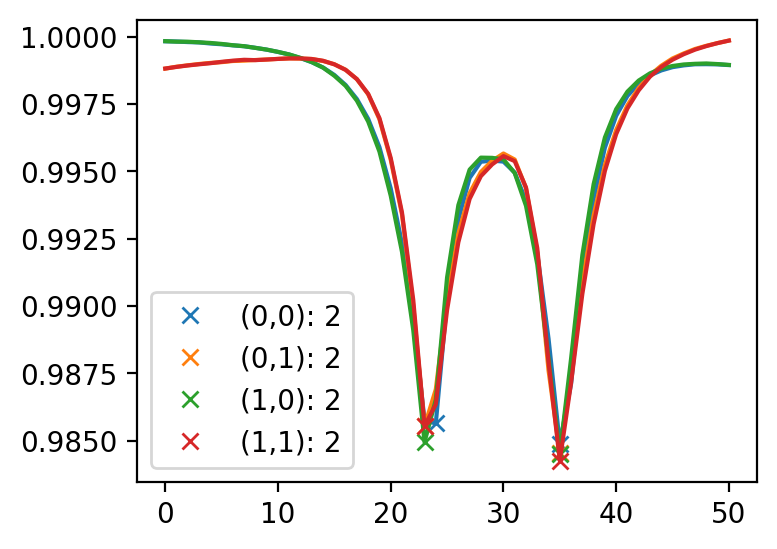

In [34]:
fit_inst.guess_model_name(check=True)

The plot shows the mean spectra (i.e. mean of all pixels) for all 4 measurement sweeps (+/- B, high/low frange). `scipy.signal.detect_peaks` determines how many peaks are in the signal. A N14 diamond should have 3 per sweep, a N15 diamond only 2 and bombarded diamonds usually only have a single peak. 

This works well in most cases, but sometimes the data is of very bad quality and as such QDMpy can fail to detect the correct model. In this case, a warning message will be displayed and you can set the model manually.

In [35]:
fit_inst.model_name = 'ESR14N'

15:11:54     INFO QDMpy._core.fit.model_name >> Setting model to ESR14N, resetting all fit results and initial parameters.
15:11:54     INFO QDMpy._core.fit._reset_fit >> Fit results have been reset.


When setting the model manually, all initial guess parameters are reset and have to be recalcualted.

In [36]:
fit_inst.model_name = 'ESR15N'

15:11:58     INFO QDMpy._core.fit.model_name >> Setting model to ESR15N, resetting all fit results and initial parameters.
15:11:58     INFO QDMpy._core.fit._reset_fit >> Fit results have been reset.


## initial  guesses

To get a good fit for the data, we need a good initial guess. This is crucial, since the fit will not be reliable if the initial guess is bad.

There are 3 parameters, which need to be guessed for each pixel: the center of the distributions (i.e. resonance), the width of the lorentzian distributions and the contrast (we assume the same contrast for all peaks).

In [37]:
from QDMpy._core import fit

### center 

I am estimating the center by using a normalized cumulative sum (i.e. from 1->0) of the spectra. The center is estimated to be the frequency where y=0.5.

### width

Similar to the center frequency, a rough estimate of the width is determined by the difference of the frequencies at two values `vmin` and `vmax`. `vmin` and `vmax` are specific to the type of model (i.e. N14, N15). For instance, the values for `vmin` and `vmax` in the N15 case (here) are: 0.4 and 0.6. Meaning the difference of the frequency at y=0.4 and y=0.6 of the normalized cumsum is estimated as the width of the lorentzian distribution.

### contrast

Finally, the contrast is simply the difference between the maximum and minimum of the data.

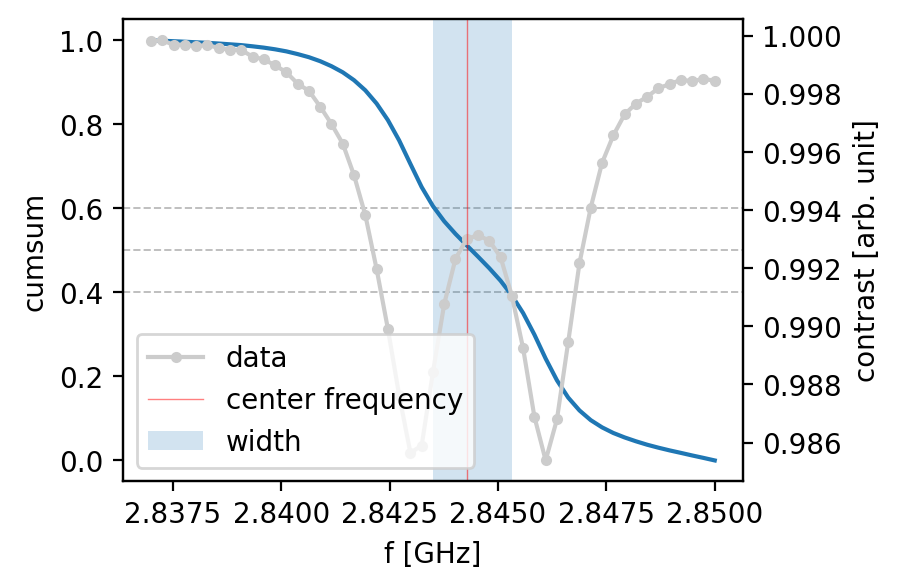

In [38]:
ax = plt.gca()
idx = 0
# calc the cumsum
pixel_data = odmr_inst.data[0,0,idx]
pixel = fit.normalized_cumsum_pixel(pixel_data)

# add horizontal lines for reference
plt.axhline(0.4, c='0.5', alpha=0.5, lw=0.7, ls='--')
plt.axhline(0.5, c='0.5', alpha=0.5, lw=0.7, ls='--')
plt.axhline(0.6, c='0.5', alpha=0.5, lw=0.7, ls='--')

# plot data
plt.plot(fit_inst.f_ghz[0], pixel, label='cumsum')
ax2 = ax.twinx()
ax2.plot(fit_inst.f_ghz[0], pixel_data, '.-', c='0.8', label='data')

# center
center = fit.guess_center_pixel(pixel_data, fit_inst.f_ghz[0])
idx = np.argmin(np.abs(fit_inst.f_ghz[0]-center))
plt.axvline(center, c='r', lw=0.5, alpha=0.5, label='center frequency')

# width
vmin, vmax = 0.4, 0.6
lidx = np.argmin(np.abs(pixel - vmin))
ridx = np.argmin(np.abs(pixel - vmax))
plt.axvspan(fit_inst.f_ghz[0,lidx], fit_inst.f_ghz[0,ridx], alpha=0.2, label='width') 
ax.set(xlabel = 'f [GHz]', ylabel='cumsum')
ax2.set(xlabel = 'f [GHz]', ylabel='contrast [arb. unit]')

plt.legend(loc='lower left')

You can see that the estimation isnt bad in this case. Let's have a look at a bad pixel:

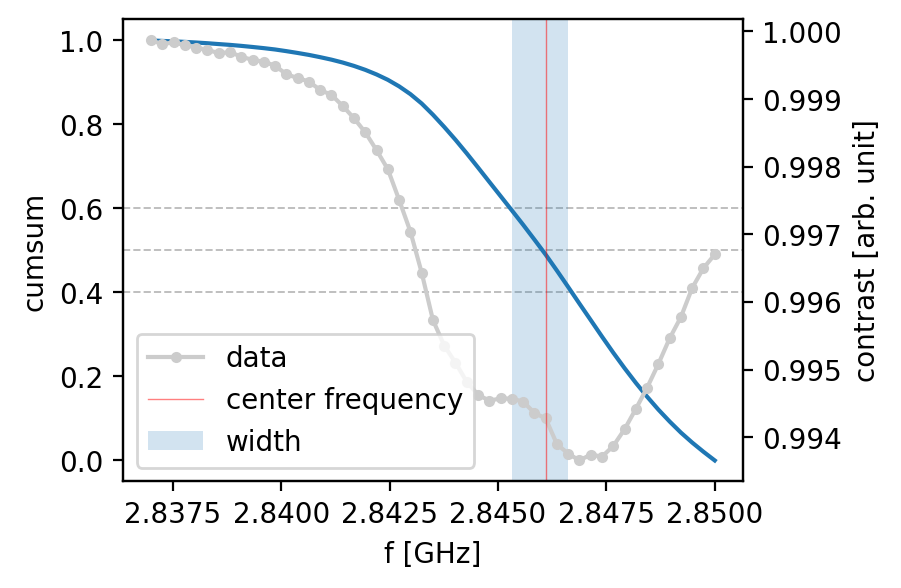

In [39]:
ax = plt.gca()
idx = odmr_inst.most_divergent_from_mean()[-1]
# calc the cumsum
pixel_data = odmr_inst.data[0,0,idx]
pixel = fit.normalized_cumsum_pixel(pixel_data)

# add horizontal lines for reference
plt.axhline(0.4, c='0.5', alpha=0.5, lw=0.7, ls='--')
plt.axhline(0.5, c='0.5', alpha=0.5, lw=0.7, ls='--')
plt.axhline(0.6, c='0.5', alpha=0.5, lw=0.7, ls='--')

# plot data
plt.plot(fit_inst.f_ghz[0], pixel, label='cumsum')
ax2 = ax.twinx()
ax2.plot(fit_inst.f_ghz[0], pixel_data, '.-', c='0.8', label='data')

# center
center = fit.guess_center_pixel(pixel_data, fit_inst.f_ghz[0])
idx = np.argmin(np.abs(fit_inst.f_ghz[0]-center))
plt.axvline(center, c='r', lw=0.5, alpha=0.5, label='center frequency')

# width
vmin, vmax = 0.4, 0.6
lidx = np.argmin(np.abs(pixel - vmin))
ridx = np.argmin(np.abs(pixel - vmax))
plt.axvspan(fit_inst.f_ghz[0,lidx], fit_inst.f_ghz[0,ridx], alpha=0.2, label='width') 
ax.set(xlabel = 'f [GHz]', ylabel='cumsum')
ax2.set(xlabel = 'f [GHz]', ylabel='contrast [arb. unit]')

plt.legend(loc='lower left')

Again, teh estimation isn't so bad, even though the width may be a little off.

## calculating the fit 
In order to do the fit calculation, call `fit_odmr` just like in the QDM object.

In [40]:
fit_inst.fit_odmr()
default = fit_inst.get_param("center").copy()
default_chi = fit_inst.get_param("chi").copy()

15:11:58     INFO QDMpy._core.fit.fit_odmr >> Fitting frange 0 from 2.837-2.850 GHz
15:11:58     INFO QDMpy._core.fit.fit_odmr >>         finished in 0.08 seconds
15:11:58     INFO QDMpy._core.fit.fit_odmr >> Fitting frange 1 from 2.887-2.900 GHz
15:11:58     INFO QDMpy._core.fit.fit_odmr >>         finished in 0.04 seconds


This determines the best fit [center, width, contrast and offset] for each pixel using the default fitting constraints (see e.g. `/home/YOU/.config/QDMpy/config.ini`). To show the used constraints, you can use:

In [41]:
fit_inst.constraints

{'center': [2, 3.1, 'FREE', 'GHz'],
 'width': [0.0001, 0.002, 'LOWER_UPPER', 'GHz'],
 'contrast_0': [0.003, 0, 'LOWER', 'a.u.'],
 'contrast_1': [0.003, 0, 'LOWER', 'a.u.'],
 'offset': [0, 0, 'FREE', 'a.u.']}

### constraints

Each entry in the dict is composed of [lower bound, upper bound, bound type, unit]. If these do not give usable results, you can set them to something better.

Note: this will not change the default values, edit the config.ini file to do that.

In [72]:
fit_inst.set_constraints('width', 1e-6, 3e-6, 'LOWER_UPPER')

15:20:53     INFO QDMpy._core.fit.set_constraints >> Setting constraints for << width >> (1e-06, 3e-06) with LOWER_UPPER
15:20:53     INFO QDMpy._core.fit._reset_fit >> Fit results have been reset.


Because this rest the calculated fit, we need to recalculate it.

In [73]:
fit_inst.fit_odmr()
change = fit_inst.get_param("center").copy()
change_chi = fit_inst.get_param("chi").copy()

15:20:54     INFO QDMpy._core.fit.fit_odmr >> Fitting frange 0 from 2.837-2.850 GHz
15:20:55     INFO QDMpy._core.fit.fit_odmr >>         finished in 0.33 seconds
15:20:55     INFO QDMpy._core.fit.fit_odmr >> Fitting frange 1 from 2.887-2.900 GHz
15:20:55     INFO QDMpy._core.fit.fit_odmr >>         finished in 0.34 seconds


### free constraints 
In some cases, it may be better to not constrain the fit. To do this, call:

In [74]:
fit_inst.set_free_constraints()

15:21:04     INFO QDMpy._core.fit.set_constraints >> Setting constraints for << center >> (None, None) with FREE
15:21:04     INFO QDMpy._core.fit.set_constraints >> Setting constraints for << width >> (None, None) with FREE
15:21:04     INFO QDMpy._core.fit.set_constraints >> Setting constraints for << contrast_0 >> (None, None) with FREE
15:21:04     INFO QDMpy._core.fit.set_constraints >> Setting constraints for << contrast_1 >> (None, None) with FREE
15:21:04     INFO QDMpy._core.fit.set_constraints >> Setting constraints for << offset >> (None, None) with FREE
15:21:04     INFO QDMpy._core.fit._reset_fit >> Fit results have been reset.


Again, the fit needs to be recalculated if we change the constraints.

In [75]:
fit_inst.fit_odmr()
free = fit_inst.get_param("center").copy()
free_chi = fit_inst.get_param("chi").copy()

15:21:04     INFO QDMpy._core.fit.fit_odmr >> Fitting frange 0 from 2.837-2.850 GHz
15:21:04     INFO QDMpy._core.fit.fit_odmr >>         finished in 0.03 seconds
15:21:04     INFO QDMpy._core.fit.fit_odmr >> Fitting frange 1 from 2.887-2.900 GHz
15:21:04     INFO QDMpy._core.fit.fit_odmr >>         finished in 0.03 seconds


Lets see if there is a big difference. First the resonance:

In [76]:
from QDMpy import plotting

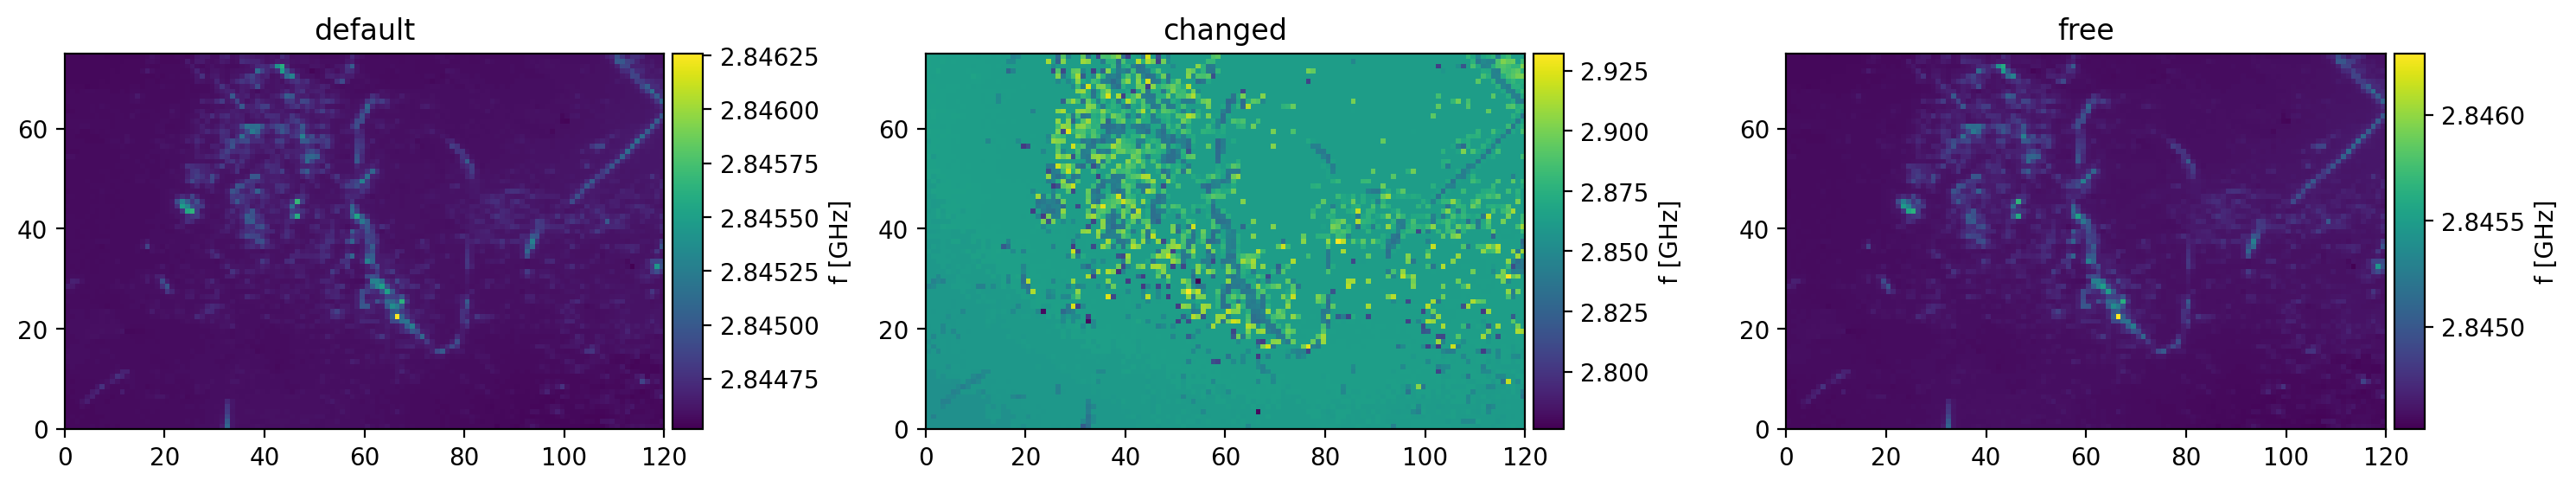

In [77]:
f, ax = plt.subplots(1,3, figsize = (15,4), sharex=False, sharey=False)

norm_percentile = (0,100) # colorscaling
im = plotting.plot_data(ax=ax[0], data=default.reshape(odmr_inst['r'].shape[:-1])[0,0], norm_percentile=norm_percentile, cmap='viridis')
plotting.add_cbar(ax[0], im, label='f [GHz]')
im = plotting.plot_data(ax=ax[1], data=change.reshape(odmr_inst['r'].shape[:-1])[0,0], norm_percentile=norm_percentile, cmap='viridis')
plotting.add_cbar(ax[1], im, label='f [GHz]')
im = plotting.plot_data(ax=ax[2], data=free.reshape(odmr_inst['r'].shape[:-1])[0,0], norm_percentile=norm_percentile, cmap='viridis')
plotting.add_cbar(ax[2], im, label='f [GHz]')

for i, a in enumerate(ax.flat):
    a.set(xlabel='', ylabel='', title=['default', 'changed', 'free'][i])
plt.tight_layout()

Here the change between the free and constrained fit is small. However, other maps (especially strong ones), the differences between constraints may be more pronounced. On the other hand, changing the constraint of the width, removes a lot of the signal in teh lower left and right og the figure. If this is "good" has to be decided by checking the data the fit for these pixels.

Looking at the misfit, shows that the changed width constraint does give worse results than the default (i.e. higher X2).

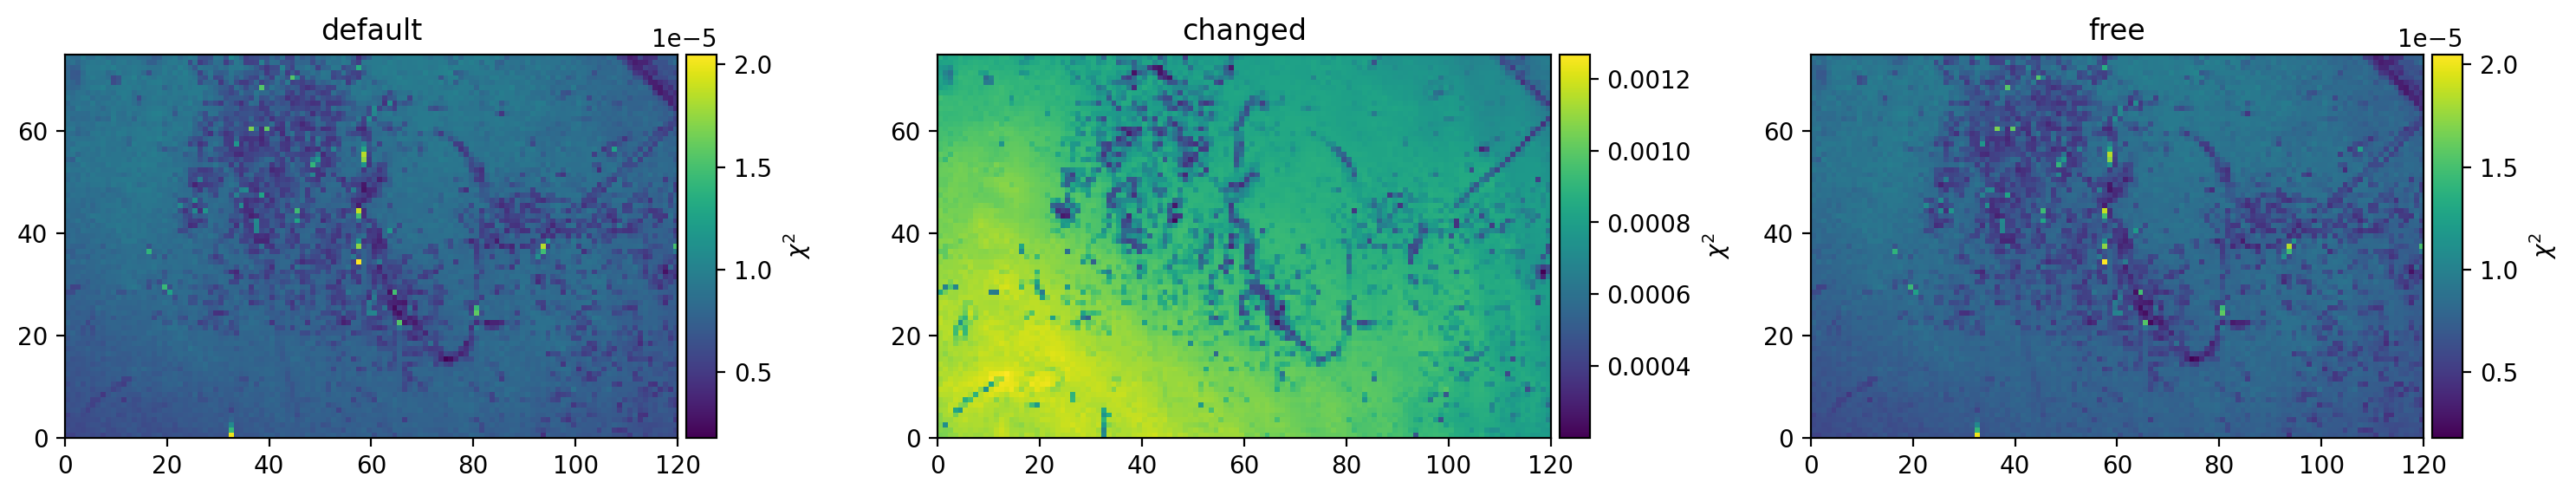

In [78]:
f, ax = plt.subplots(1,3, figsize = (15,4), sharex=False, sharey=False)
# ax = ax.flatten()
im = plotting.plot_data(ax=ax[0], data=default_chi.reshape(odmr_inst['r'].shape[:-1])[0,0], norm_percentile=norm_percentile, cmap='viridis')
plotting.add_cbar(ax[0], im, label='$\chi^2$')
im = plotting.plot_data(ax=ax[1], data=change_chi.reshape(odmr_inst['r'].shape[:-1])[0,0], norm_percentile=norm_percentile, cmap='viridis')
plotting.add_cbar(ax[1], im, label='$\chi^2$')
im = plotting.plot_data(ax=ax[2], data=free_chi.reshape(odmr_inst['r'].shape[:-1])[0,0], norm_percentile=norm_percentile, cmap='viridis')
plotting.add_cbar(ax[2], im, label='$\chi^2$')

for i, a in enumerate(ax.flat):
    a.set(xlabel='', ylabel='', title=['default', 'changed', 'free'][i])
plt.tight_layout()

# QDM object

The QDM object is a container to handle the above computations (ODMR, fit) and calculate the magnetic fields from the data of the fit (i.e. resonance frequencies).

In [79]:
from QDMpy.core import QDM

In order to bypass the creation of an ODMR and Fit object, you can create a new instance of `QDM` using the `QDM.from_qdmio` method, justy like before. Pass the folder with the data and the instance is created automatically. However, in contrast to the ODMR object, the folder also needs to contain a `LASER.csv` and `LED.csv` (`.jpg` work too but csv is preferred). 

In [89]:
qdm_inst = QDM.from_qdmio(data_folder=path_to_the_qdm_datafolder)

15:27:26     INFO QDMpy._core.qdm.from_qdmio >> Initializing QDM object from QDMio data in /home/mike/github/QDMpy/tests/data/utrecht_test_data
15:27:26     INFO QDMpy._core.qdm.from_qdmio >> Reading 2 led, 2 laser files.
15:27:26     INFO QDMpy._core.odmr.from_qdmio >> Reading 2 run_* files.
15:27:27     INFO QDMpy._core.odmr.__init__ >> ODMR data object initialized
15:27:27     INFO QDMpy._core.odmr.__init__ >> ODMR data format is [polarity, f_range, n_pixels, n_freqs]
15:27:27     INFO QDMpy._core.odmr.__init__ >> read parameter shape: data: (2, 2, 36000, 51)
15:27:27     INFO QDMpy._core.odmr.__init__ >>                       scan_dimensions: [150 240]
15:27:27     INFO QDMpy._core.odmr.__init__ >>                       frequencies: (2, 51)
15:27:27     INFO QDMpy._core.odmr.__init__ >>                       n(freqs): 51
15:27:27     INFO QDMpy._core.qdm.__init__ >> Initializing QDM object.
15:27:27     INFO QDMpy._core.qdm.__init__ >> Working directory: "/home/mike/github/QDMpy/te

If you look at the log, you can see that we create an `ODMR` object first, pass the data to create a `Fit` object and then create the `QDM` object. You can access the instances and all their methods with:

In [90]:
# the ODMR object instance
type(qdm_inst.odmr)

QDMpy._core.odmr.ODMR

In [91]:
# the Fit object instance
type(qdm_inst.fit)

QDMpy._core.fit.Fit

## Data manipulation
### Binning (again)
As mentioned before, the test data is already binned with `bin_factor = 8`. Therefore, binning to anything lower than 8 is not possible. The images (LASER, LED) on the other hand have not been topuched, which means that the data size does not correspond with the image siz and has to be dealt with internally (see: `pre_binfactor`).

Internally, `QDM.bin_data` is just a wrapper around the `ODMR.bin_data` method and as such should behave just the same (with the exception of the pre_binning, needed for datasets, where `img_size != data_size`).

In [92]:
qdm_inst.bin_data(8) # anything with bin_factor < 8 will raise an error

15:27:30     INFO QDMpy._core.qdm.bin_data >> bin_factor is already set to the desired value of << 8 >>


Just like `bin_data`, `QDM.correct_glob_fluorescence` is a wrapper of `ODMR.correct_glob_fluorescence` and behaves in very much the same way.

In [95]:
qdm_inst.correct_glob_fluorescence(0.2)

15:28:13     INFO QDMpy._core.odmr._correct_glob_fluorescence >> Correcting for global fluorescence with value 0.2
15:28:13     INFO QDMpy._core.fit.data >> Data changed, fits need to be recalculated!


## fitting
Fitting the data is obviously the main goal. The `Fit` objects handles all that and the most important methods are wrapped in the `QDM` onject. So you can simply call `QDM.fit_odmr()` and dont need to write `QDM.fit.fit_odmr()`.

In [96]:
qdm_inst.fit_odmr()

15:28:30     INFO QDMpy._core.fit.fit_odmr >> Fitting frange 0 from 2.837-2.850 GHz
15:28:31     INFO QDMpy._core.fit.fit_odmr >>         finished in 0.40 seconds
15:28:31     INFO QDMpy._core.fit.fit_odmr >> Fitting frange 1 from 2.887-2.900 GHz
15:28:31     INFO QDMpy._core.fit.fit_odmr >>         finished in 0.37 seconds


Also changing the fit restraints is wrapped and you can use `QDM.set_constraints` to change them. Remember, this resets the fit.

In [97]:
qdm_inst.set_constraints('width', 1e-4, 1e-5)

15:28:38     INFO QDMpy._core.fit.set_constraints >> Setting constraints for << width >> (0.0001, 1e-05) with LOWER_UPPER
15:28:38     INFO QDMpy._core.fit._reset_fit >> Fit results have been reset.


In [98]:
qdm_inst.fit_odmr()

15:28:39     INFO QDMpy._core.fit.fit_odmr >> Fitting frange 0 from 2.837-2.850 GHz
15:28:41     INFO QDMpy._core.fit.fit_odmr >>         finished in 2.05 seconds
15:28:41     INFO QDMpy._core.fit.fit_odmr >> Fitting frange 1 from 2.887-2.900 GHz
15:28:43     INFO QDMpy._core.fit.fit_odmr >>         finished in 1.89 seconds


In [110]:
qdm_inst.set_constraints('width', None, None, 'FREE')
qdm_inst.fit_odmr()

15:37:44     INFO QDMpy._core.fit.set_constraints >> Setting constraints for << width >> (None, None) with FREE
15:37:44     INFO QDMpy._core.fit._reset_fit >> Fit results have been reset.
15:37:44     INFO QDMpy._core.fit.fit_odmr >> Fitting frange 0 from 2.837-2.850 GHz
15:37:44     INFO QDMpy._core.fit.fit_odmr >>         finished in 0.43 seconds
15:37:44     INFO QDMpy._core.fit.fit_odmr >> Fitting frange 1 from 2.887-2.900 GHz
15:37:45     INFO QDMpy._core.fit.fit_odmr >>         finished in 0.43 seconds


## Results

The results of the fit are contained in tehrh `Fit` object. To access them from teh QDM instance, you can use `QDM.get_param` with one of the following parameters:

1. resonance
2. width
3. contrast
    1. `contrast` gives contrast for all peaks
    1. `contrast_n` gives specific contrast for peak n
    2. `mean_contrast` if you want the mean contrast
4. chi2 for chi squared of the fits
5. states of the fit (i.e. if it failed or not)
6. num: number of iterations to fit

By default it resurns the data in  the correct "image shape" but you can specify `reshape = False` to get the original shape.

In [99]:
'reshaped:', qdm_inst.get_param('num').shape, 'original shape:', qdm_inst.get_param('num', reshape=False).shape

('reshaped:', (2, 2, 150, 240), 'original shape:', (2, 2, 36000))

The `contrast_n` has an extra dimension with [npeak, pol, frange, y, x]. So that `qdm_inst.get_param('contrast')[0,1,0,99,42]` will return the contrast of the first peak in the second polarity of the lower field range of pixel (42,99).

In [59]:
qdm_inst.get_param('contrast').shape, 'or not reshapes:', qdm_inst.get_param('contrast', reshape=False).shape

((2, 2, 2, 150, 240), 'or not reshapes:', (2, 2, 36000, 2))

## BUG

In [100]:
c = qdm_inst.get_param('contrast', reshape=False)
c_ = qdm_inst.get_param('contrast')

In [101]:
c[0,0,0,1], c_[:,:,:,0,0] 

(1.3103627,
 array([[[0.04570853, 0.0113653 ],
         [0.66787535, 0.04735866]],
 
        [[1.8146073 , 0.05189358],
         [1.5091494 , 0.03429492]]], dtype=float32))

<AxesSubplot: >

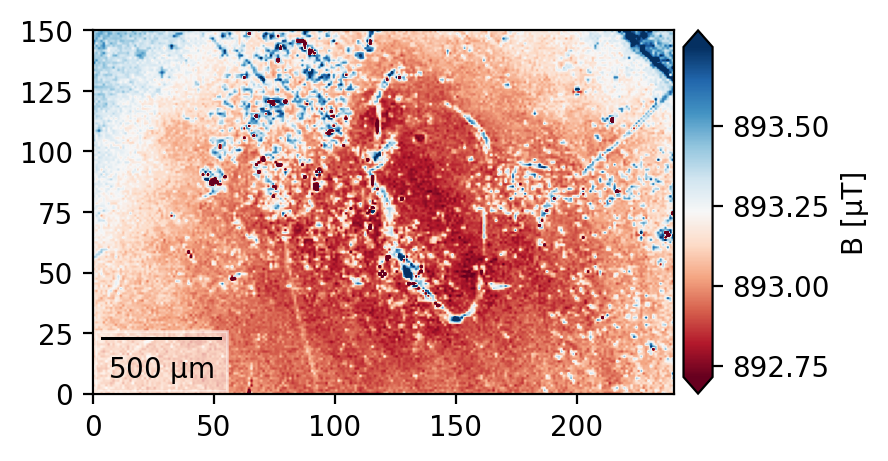

In [117]:
qdm_inst.plot(remanence=False, norm_percentile=(0.5,99.5), scalebar=10e-6)

In [142]:
from QDMpy._core.convert import project, b111_to_bxyz

In [121]:
b111 = qdm_inst.b111_remanent

In [132]:
bz = project(np.stack([b111.reshape(-1),b111.reshape(-1),b111.reshape(-1)]).T, [0,0,1])

16:27:37     INFO QDMpy.get_unit_vector >> Getting unit vector from rotation angle 0 along direction vector [0.         0.81649658 0.57735027]


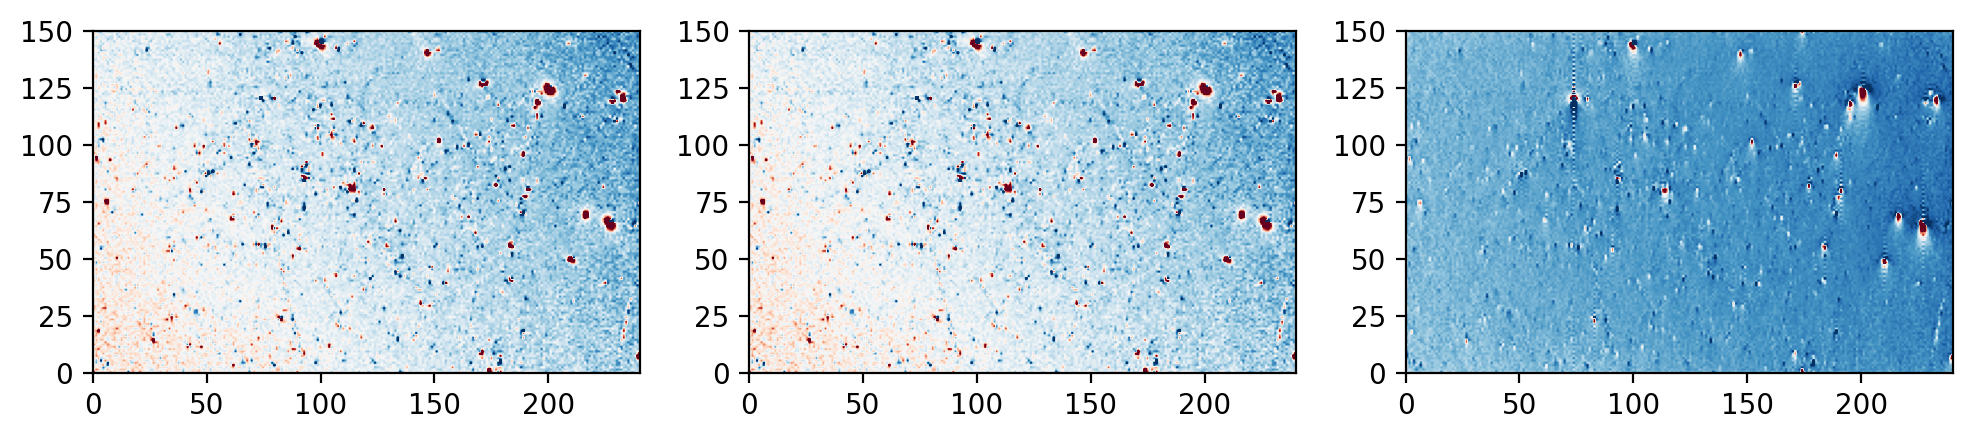

In [144]:
f, ax = plt.subplots(1,3, figsize = (12,4), sharex=False, sharey=False)
# ax = ax.flatten()
plotting.plot_data(data=qdm_inst.b111_remanent, ax=ax[0], norm_percentile=(0.5,99.5))
plotting.plot_data(data=bz.reshape(qdm_inst.b111_remanent.shape), ax=ax[1], norm_percentile=(0.5,99.5))
plotting.plot_data(data=b111_to_bxyz(qdm_inst.b111_remanent)[2], ax=ax[2], norm_percentile=(0.5,99.5))

In [146]:
np.linalg.norm([1,2,3]), np.linalg.norm([3.74,0,0]),

(3.7416573867739413, 3.74)

# Some additional thoughts 

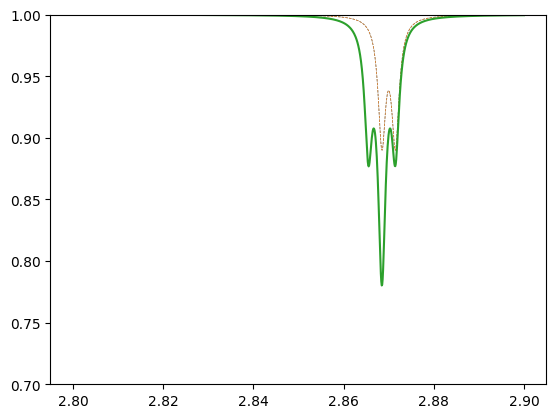

interactive(children=(FloatSlider(value=0.0, description='fsec', max=5.0, step=0.02), Output()), _dom_classes=…

In [1]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append('/Users/mike/github/QDMpy/src')

from QDMpy._core.models import esr15n, esr15n_folded

def secondary(fsec):
    f = np.linspace(2.8,2.9, 1000)
    plt.plot(f, esr15n(f, [2.87, 0.001, 0.1, 0.1, 0]), '--', lw=0.5)
    plt.plot(f, esr15n(f-fsec/1000, [2.87, 0.001, 0.1, 0.1, 0]),'--', lw=0.5)
    
    plt.plot(f, esr15n_folded(f, [2.87, 0.001, 0.1, 0.1, 0, fsec/1000]))
    plt.ylim(0.7,1)
interact(secondary, fsec=widgets.FloatSlider(min=0, max=5, step=0.02, value=0));



In [2]:
sys.path

['/Users/mike/github/QDMpy',
 '/Users/mike/github/QDMpy',
 '/Users/mike/github',
 '/Users/mike/Dropbox/science/_projects',
 '/opt/homebrew/Cellar/python@3.10/3.10.8/Frameworks/Python.framework/Versions/3.10/lib/python310.zip',
 '/opt/homebrew/Cellar/python@3.10/3.10.8/Frameworks/Python.framework/Versions/3.10/lib/python3.10',
 '/opt/homebrew/Cellar/python@3.10/3.10.8/Frameworks/Python.framework/Versions/3.10/lib/python3.10/lib-dynload',
 '',
 '/Users/mike/github/QDMpy/.venv/lib/python3.10/site-packages']